# Data Demo
In this notebook we display all the data need it for the platform. 

The data is also compiled together with the narrative in [this document](https://docs.google.com/document/d/1D5qpHKlfLvYt0Tu6EGf2ami0Od7KIjohb6SEDw66kDg/edit#).

We will also transforms vector type data into MBTiles using tippecanoe.

# Setup
## Library import
We import all the required Python libraries

In [1]:
import ast
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

## Utils
**create_mbtiles**

In [11]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

# Data import

## Provincias

In [2]:
provincias = gpd.read_file(f'../../datasets/raw/georegions/Provincias/Provincias.shp')
provincias.sort_values(['CO_CCAA', 'CO_PROVINC'], inplace = True)

## Comarcas Agrarias
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/agricultura/)**

In [3]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')
comarcas_agr.sort_values(['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'], inplace = True)

# Remove Canarias, Ceuta, and Melilla
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]
comarcas_agr = comarcas_agr.reset_index(drop=True)

## Municipios de España
**[Data source](https://opendata.esri.es/datasets/53229f5912e04f1ba6dddb70a5abeb72_0/explore?location=43.017075%2C9.288571%2C5.20)**

In [4]:
municipios = gpd.read_file(f'../../datasets/raw/georegions/Municipios/Municipios_IGN.shp')
municipios.sort_values(['CODNUT1', 'CODNUT2', 'CODNUT3', 'CODIGOINE'], inplace = True)

# Remove Canarias, Ceuta, and Melilla
municipios = municipios[~municipios['CODNUT2'].isin(['ES70', 'ES63', 'ES64'])]
municipios = municipios.reset_index(drop=True)

## Denominaciones de Origen Protegidas
**[Data source](https://www.mapa.gob.es/es/cartografia-y-sig/ide/descargas/alimentacion/vinos.aspx)**

In [5]:
vinos_dop = gpd.read_file('../../datasets/raw/georegions/Vinos/calidaddiferenciada_vinos_tcm30-376469/CalidadDiferenciada_Vinos.shp')

# Remove Canarias, Ceuta, and Melilla
vinos_dop = vinos_dop[~vinos_dop['ZON_DS_NOM'].isin(['Gran Canaria', 'La Gomera', 'El Hierro',
                                                     'Valle de Güimar', 'Valle de la Orotava', 
                                                     'Abona', 'Tacoronte-Acentejo', 'Ycoden-Daute-Isora',
                                                     'La Palma', 'Lanzarote', 'Las Islas Canarias'])]
vinos_dop = vinos_dop.reset_index(drop=True)

# Data visualization

## Emisiones por municipio
**Read data**

In [6]:
df = pd.read_csv('../../datasets/processed/CO2_emissions_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[df['indicator'] == 'CO2_emissions'].astype({'value': 'float64'})
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
gdf.head()

,CODIGOINE,dataset,indicator,scenario,value,year,unit,geometry
0,15001,OpenGHGMap,CO2_emissions,NaN,165448.0,2018,t,"POLYGON ((-8.35892 43.14721, -8.35864 43.14764..."
1,15002,OpenGHGMap,CO2_emissions,NaN,43288.0,2018,t,"POLYGON ((-8.72471 42.88868, -8.72403 42.88872..."
2,15003,OpenGHGMap,CO2_emissions,NaN,64922.0,2018,t,"POLYGON ((-8.11605 43.21256, -8.11120 43.21299..."
3,15004,OpenGHGMap,CO2_emissions,NaN,85412.0,2018,t,"MULTIPOLYGON (((-8.26941 43.42891, -8.26951 43..."
4,15005,OpenGHGMap,CO2_emissions,NaN,1117753.0,2018,t,"MULTIPOLYGON (((-8.55475 43.31382, -8.55483 43..."


**Map**

Text(0.5, 1.0, 'Emisiones de CO2 por municipio [t CO2]')

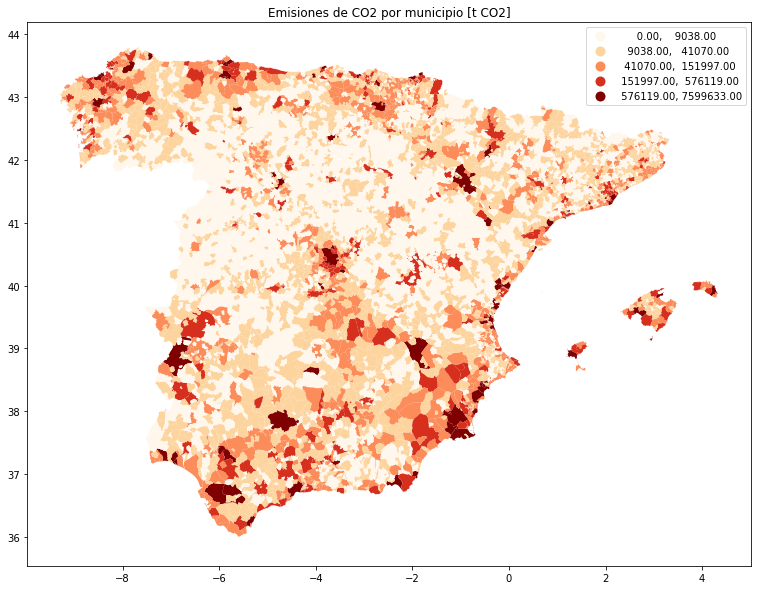

In [7]:
fig, ax = plt.subplots(1,1,figsize=(20,10))

gdf.plot(ax=ax, column='value', cmap='OrRd', scheme='jenkscaspall', legend=True)
ax.set_title('Emisiones de CO2 por municipio [t CO2]')
#plt.savefig('emissions.svg',dpi=300)  
#plt.savefig('emissions.png',dpi=300)

### Create MBTiles
#### **Save GeoDataFrame as GeoJSON**

In [10]:
gdf.to_file("../../datasets/processed/MBTiles/OpenGHGMap.json", driver="GeoJSON")

#### **Create MBTiles**

In [14]:
layer_name = "OpenGHGMap"
source_path = "../../datasets/processed/MBTiles/OpenGHGMap.json"
dest_path = "../../datasets/processed/MBTiles/OpenGHGMap.mbtiles"
create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

Processing: tippecanoe -o ../../datasets/processed/MBTiles/OpenGHGMap.mbtiles -l OpenGHGMap -zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel ../../datasets/processed/MBTiles/OpenGHGMap.json


../../datasets/processed/MBTiles/OpenGHGMap.json:152: Found ] at top level
../../datasets/processed/MBTiles/OpenGHGMap.json:69: Reached EOF without all containers being closed
In JSON object {"type":"FeatureCollection","crs":{"type":"name","properties":{"name":"urn:ogc:def:crs:OGC:1.3:CRS84"}},"features":[]}
8115 features, 17499210 bytes of geometry, 194760 bytes of separate metadata, 93248 bytes of string pool
Choosing a maxzoom of -z4 for features about 25989 feet (7922 meters) apart
Choosing a maxzoom of -z10 for resolution of about 342 feet (104 meters) within features


Task created
Finished processing


  99.9%  10/496/399  


**Tooltip**

In [ ]:
df_cat = df[df['indicator'] == 'emissions_by_category']
df_cat = gpd.GeoDataFrame(pd.merge(df_cat, municipios[['CODIGOINE', 'NAMEUNIT']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
cats = ast.literal_eval(df_cat[df_cat['NAMEUNIT'] == 'Málaga']['value'].iloc[0])

In [ ]:
# Data
categories = list(cats.keys())
values = list(cats.values())
c = ["#151515", "#337735", "#04BA09", "#DD9201", "#DD2901", "#8F1D03"]

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, values, color = c)
 
plt.title('Emisions sources')
plt.ylabel('[t CO2]')

plt.show()

## Aumento de temperaturas proyectadas por municipio
**Read data**

In [ ]:
indicator = 'mean_Tmean_Yearly_change'
scenario = 'rcp85'
year = '2065 - 2095'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='inferno', legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')
#plt.savefig('temp_change.svg',dpi=300)  
#plt.savefig('temp_change.png',dpi=300)

[Improve with folium](https://github.com/python-visualization/folium/blob/master/examples/GeoJSON_and_choropleth.ipynb)

In [ ]:
#m = folium.Map([40, -4], zoom_start=4)
#
#folium.GeoJson(
#    gdf,
#).add_to(m)
#
#m

**Tooltip**

In [ ]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

In [ ]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(14,5))

# Plot
plt.bar(categories, values, color = "#337735")
 
plt.title('Aumento de temperaturas proyectadas en Rioja')
plt.ylabel(f'{indicator} [{unit}]')

plt.show()

## Evolución de temperatura en España
**Read data**

In [ ]:
df = pd.read_csv(f'../../datasets/processed/annual_average_temperature_spain.csv')

**Display data**

In [ ]:
fig, ax = plt.subplots(figsize=(10,7.5))

ax.plot(df[df['scenario'] == 'rcp45']['year'], df[df['scenario'] == 'rcp45']['value'], label='rcp45', color = '#04BA09')
ax.plot(df[df['scenario'] == 'rcp85']['year'], df[df['scenario'] == 'rcp85']['value'], label='rcp85', color = '#DD2901')

# call with no parameters
ax.legend()
ax.set_title('Evolución de la temperatura media anual en España')
ax.set_xlabel('Años')
ax.set_ylabel('Temperatura (ºC)')

## Mapa de cultivos
**Read data**

In [ ]:
gdf_corine = gpd.read_file('../../datasets/raw/crops/CLC2018_GDB/CLC2018_ES.gdb', driver="FileGDB", layer='CLC18_ES')
# Re-Project
gdf_corine = gdf_corine.to_crs("EPSG:4326")
gdf_corine = gdf_corine.set_crs("EPSG:4326")

**Display data**

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))

gdf_corine[gdf_corine['CODE_18'].isin(['211', '212'])].plot(ax=ax, color='#DD9201', label= 'Cereal', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['223'])].plot(ax=ax, color='#337735', label= 'Olivar', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['244'])].plot(ax=ax, color='#04BA09', label= 'Dehesa', legend=True)
gdf_corine[gdf_corine['CODE_18'].isin(['221'])].plot(ax=ax, color='#8F1D03', label= 'Viñedo', legend=True)

ax.set_title('CORINE Land Cover 2018')

# Adding custom legend
pmark1 = mpatches.Patch(facecolor='#DD9201',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Cereal')

pmark2 = mpatches.Patch(facecolor='#337735',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Olivar')

pmark3 = mpatches.Patch(facecolor='#04BA09',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Dehesa')

pmark4 = mpatches.Patch(facecolor='#8F1D03',
                       edgecolor='white',
                       linestyle='-',
                       alpha=1,
                       label='Viñedo')

handles, _ = ax.get_legend_handles_labels()
ax.legend(
    handles=[
        *handles,
        pmark1,
        pmark2,
        pmark3,
        pmark4,
    ],
    title="Cultivos",
    loc='lower right',
    ncol=1,
    shadow=True)

# show figure
plt.rcParams['legend.title_fontsize'] = 10
plt.show()

## Población dependiente de agricultura
**Read data**

In [ ]:
df = pd.read_csv(f'../../datasets/processed/población_activa.csv')
gdf = pd.merge(provincias.astype({'CO_CCAA': int, 'CO_PROVINC': int}), df, how='left', on=['CO_CCAA','CO_PROVINC'])
gdf.head()

**Display data**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1) 

gdf.plot(ax=ax, column='value', cmap='gist_earth', edgecolor='grey', legend=True, cax=cax, legend_kwds={'label': 'Porcentage de población activa [%]'})
ax.set_title('Población dependiente de agricultura')

## Duración de las sequías
**Read data**

In [ ]:
indicator = 'dry-spells_maximum-length'
scenario = 'rcp85'
year = '2081 - 2100'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='terrain', legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

**Tooltip**

In [ ]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

In [ ]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, values, color = "#337735")
 
plt.title('Duración de las sequías en Rioja')
plt.ylabel(f'{indicator} [{unit}]')

plt.show()

## Precipitación durante el trimestre más húmedo

To compute the total precipitation sum over the month, a conversion factor should be applied of 3600x24x91.3 (average number of days per quarter)*1000  (mm month-1).

**Read data**

In [ ]:
conversion_factor = 3600*24*91.3*1000

In [ ]:
indicator = 'BIO16'
scenario = 'rcp85'
year = '2081 - 2100'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_municipios.csv')
df = df.astype({'CODIGOINE':int})
gdf = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(gdf, municipios[['CODIGOINE', 'geometry']].astype({'CODIGOINE':int}), how='left', on='CODIGOINE'))
unit = gdf['unit'].iloc[0]
# From m/s to mm/month
gdf['value'] = gdf['value'].apply(lambda x: x*conversion_factor)
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='Blues', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [mm/month]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

**Tooltip**

In [ ]:
gdf_tool = df[(df['indicator'] == indicator) & (df['scenario'] == scenario)]

In [ ]:
# Data
categories = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].year)
values = list(gdf_tool[gdf_tool['CODIGOINE'] == 4078].value)

plt.figure(figsize=(10,5))

# Plot
plt.bar(categories, (np.array(values)*conversion_factor), color = "#337735")
 
plt.title('Precipitación durante el trimestre más húmedo en Rioja')
plt.ylabel(f'{indicator} [mm/month]')

plt.show()

# Viñedo
## Mapa de zonificación
**Read data**

In [ ]:
spain = gpd.read_file('../../datasets/processed/spain.geojson', driver='GeoJSON')
gdf_grid = gpd.read_file('../../datasets/processed/rejilla_viñedos.geojson')  
df_zone = pd.read_csv(f'../../datasets/processed/zonas_alto_potencial_climático_viñedos.csv')

gdf_zone = gpd.GeoDataFrame(pd.merge(df_zone, gdf_grid, how='left', on='DENOMINACI'))

**Display data**

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

plt.rc('axes', titlesize=20) 

spain.plot(ax=ax1, color='w', edgecolor='k')
vinos_dop.plot(ax=ax1, color='w', edgecolor='k')
gdf_zone[(gdf_zone['scenario'] == 'baseline') & (gdf_zone['year'] == '1971-2000')].plot(ax=ax1, column='value', alpha=.9)
ax1.set_title('1971-2000')
ax1.axis('off')

spain.plot(ax=ax2, color='w', edgecolor='k')
vinos_dop.plot(ax=ax2, color='w', edgecolor='k')
gdf_zone[(gdf_zone['scenario'] == 'rcp45') & (gdf_zone['year'] == '2021-2050')].plot(ax=ax2, column='value', alpha=.9)
vinos_dop.plot(ax=ax2, color='w', edgecolor='k', alpha=0.1)
ax2.set_title('2021-2050')
ax2.axis('off')

## Duración de las olas de calor
**Read data**

In [ ]:
indicator = 'HWD_EU_climate'
scenario = 'rcp85'
year = '2065 - 2095'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_denominaciones_de_origen_protegidas.csv')
df = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(df, vinos_dop[['OBJECTID', 'geometry']], how='left', on='OBJECTID'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='gist_heat_r', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

## Duración de las sequías
**Read data**

In [ ]:
indicator = 'dry-spells_maximum-length'
scenario = 'rcp85'
year = '2081 - 2100'

In [ ]:
df = pd.read_csv('../../datasets/processed/climate_indicators_denominaciones_de_origen_protegidas.csv')
df = df[(df['indicator'] == indicator) & (df['scenario'] == scenario) & (df['year'] == year)]
gdf = gpd.GeoDataFrame(pd.merge(df, vinos_dop[['OBJECTID', 'geometry']], how='left', on='OBJECTID'))
unit = gdf['unit'].iloc[0]
gdf.head()

**Map**

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-1.5) 
gdf.plot(ax=ax, column='value', cmap='terrain', edgecolor='grey', linewidth=0.2, legend=True, cax=cax, legend_kwds={'label': f'{indicator} [{unit}]'})
ax.set_title(f'time = {year}, scenario = {scenario}')

# Cereales
## Mapa de zonificación
**Read data**